# Land Cover processing

The outputs of this notebook are used in subsequent land use conflict analysis.

### Import libraries

In [116]:
import geopandas as gpd
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

### Land cover changes between 2000 and 2022

Load level 2 land cover datasets

In [117]:
 # Folder containing the files
covers_path = "./data/cover/coverl2" 

# List all files in the folder
files = [f for f in os.listdir(covers_path)]

lc = {}

for file in files:
    path = os.path.join(covers_path, file)
    gdf = gpd.read_file(path)
    lc[file] = gdf

In [118]:
for filename, data in lc.items():
    if "2000" in filename:
        data['year'] = 2000
    elif "2010" in filename:
        data['year'] = 2010
    elif "2022" in filename:
        data['year'] = 2022

Merge by department

In [119]:
ara=pd.concat([lc['ara_cover2000l2.gpkg'], lc['ara_cover2010l2.gpkg'], lc['ara_cover2022l2.gpkg']], ignore_index=True)
casa=pd.concat([lc['casa_cover2000l2.gpkg'], lc['casa_cover2010l2.gpkg'], lc['casa_cover2022l2.gpkg']], ignore_index=True)
meta=pd.concat([lc['meta_cover2000l2.gpkg'], lc['meta_cover2010l2.gpkg'], lc['meta_cover2022l2.gpkg']], ignore_index=True)

Calculate area in square kilometers

In [120]:
ara["Area"] = ara.geometry.area / 1e6
casa["Area"] = casa.geometry.area / 1e6
meta["Area"] = meta.geometry.area / 1e6

Remove '9.9 Unknown' class related to clouds presence

In [121]:
ara_noclouds = ara[ara["level2"] != "9.9 Unknown"]
casa_noclouds = casa[casa["level2"] != "9.9 Unknown"]
meta_noclouds = meta[meta["level2"] != "9.9 Unknown"]

Group by level2 and year to create unique cells (one per class per year)

In [122]:
ara_level2_year = ara_noclouds.dissolve(by=['level2', 'year'], as_index=False)
# Calculate area for each group
ara_level2_year['Area'] = ara_level2_year.geometry.area / 1e6
# Keep only the columns we need
ara_level2_year = ara_level2_year[['level2', 'year', 'Area', 'geometry']]

KeyboardInterrupt: 

In [ ]:
casa_level2_year = casa_noclouds.dissolve(by=['level2', 'year'], as_index=False)
# Calculate area for each group
casa_level2_year['Area'] = casa_level2_year.geometry.area / 1e6
# Keep only the columns we need
casa_level2_year = casa_level2_year[['level2', 'year', 'Area', 'geometry']]

In [ ]:
meta_level2_year = meta_noclouds.dissolve(by=['level2', 'year'], as_index=False)
# Calculate area for each group
meta_level2_year['Area'] = meta_level2_year.geometry.area / 1e6
# Keep only the columns we need
meta_level2_year = meta_level2_year[['level2', 'year', 'Area', 'geometry']]

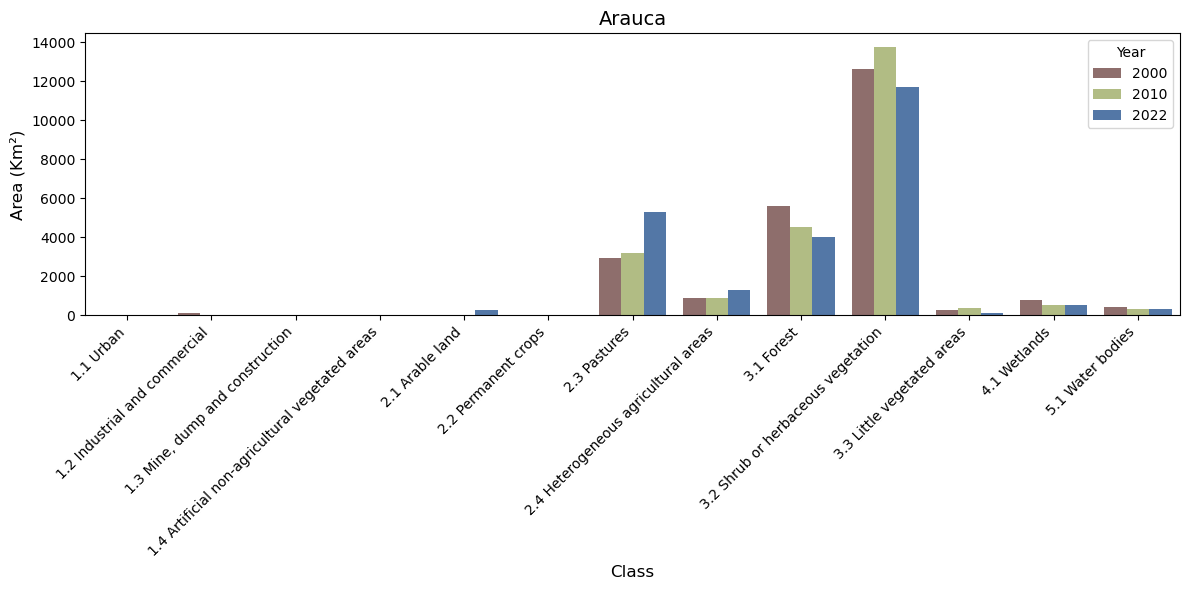

In [ ]:
# Arauca plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=ara_level2_year ,
    x="level2",
    y="Area",
    hue="year",
    palette=["#946966", "#b6c57b", "#4575b4"],
    errorbar=None,
    order=sorted(ara_level2_year["level2"].unique())
)

# Style the plot
plt.title("Arauca", fontsize=14)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Area (Km²)", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title="Year")
plt.tight_layout()
plt.show()

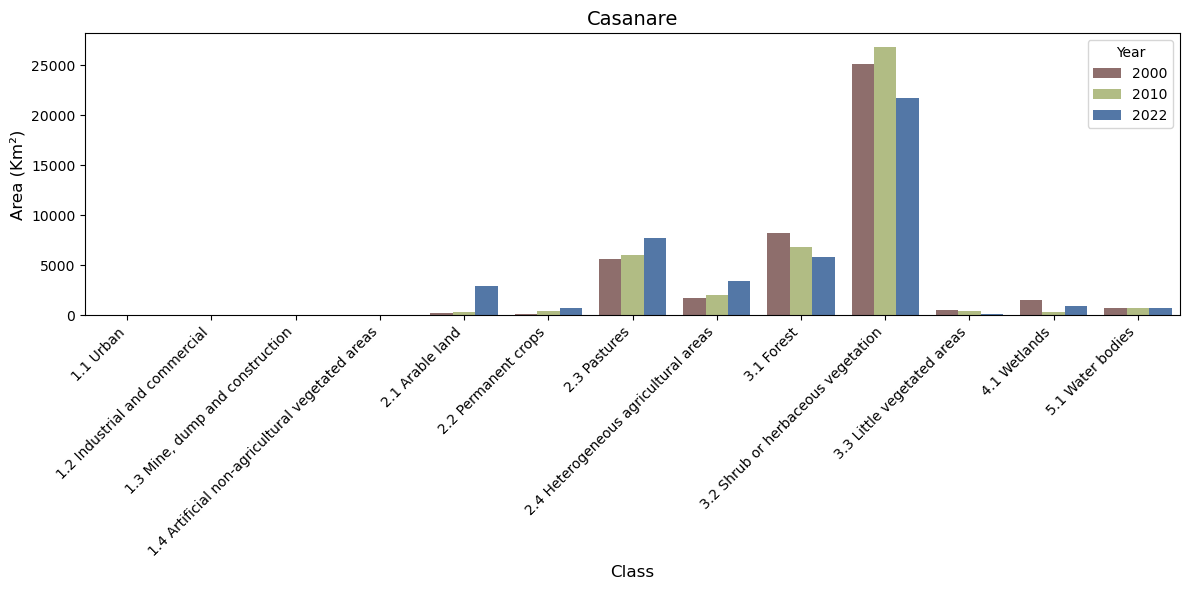

In [ ]:
# Casanare plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=casa_level2_year,
    x="level2",
    y="Area",
    hue="year",
    palette=["#946966", "#b6c57b", "#4575b4"],
    errorbar=None,
    order=sorted(casa_level2_year["level2"].unique())
)

# Style the plot
plt.title("Casanare", fontsize=14)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Area (Km²)", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title="Year")
plt.tight_layout()
plt.show()

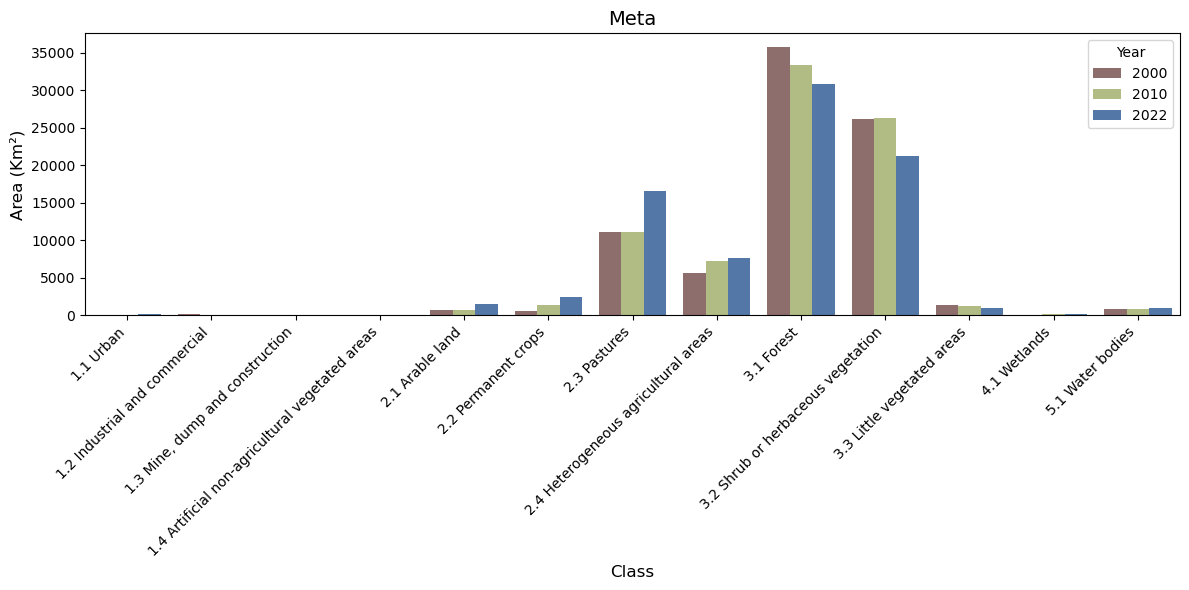

In [ ]:
# Meta plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=meta_level2_year,
    x="level2",
    y="Area",
    hue="year",
    palette=["#946966", "#b6c57b", "#4575b4"],
    errorbar=None,
    order=sorted(meta_level2_year["level2"].unique())
)

# Style the plot
plt.title("Meta", fontsize=14)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Area (Km²)", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title="Year")
plt.tight_layout()
plt.show()

In [ ]:
ara_2000=ara_level2_year[ara_level2_year["year"]==2000]
ara_2010=ara_level2_year[ara_level2_year["year"]==2010]
ara_2022=ara_level2_year[ara_level2_year["year"]==2022]

casa_2000=casa_level2_year[casa_level2_year["year"]==2000]
casa_2010=casa_level2_year[casa_level2_year["year"]==2010]
casa_2022=casa_level2_year[casa_level2_year["year"]==2022]

meta_2000=meta_level2_year[meta_level2_year["year"]==2000]
meta_2010=meta_level2_year[meta_level2_year["year"]==2010]
meta_2022=meta_level2_year[meta_level2_year["year"]==2022]

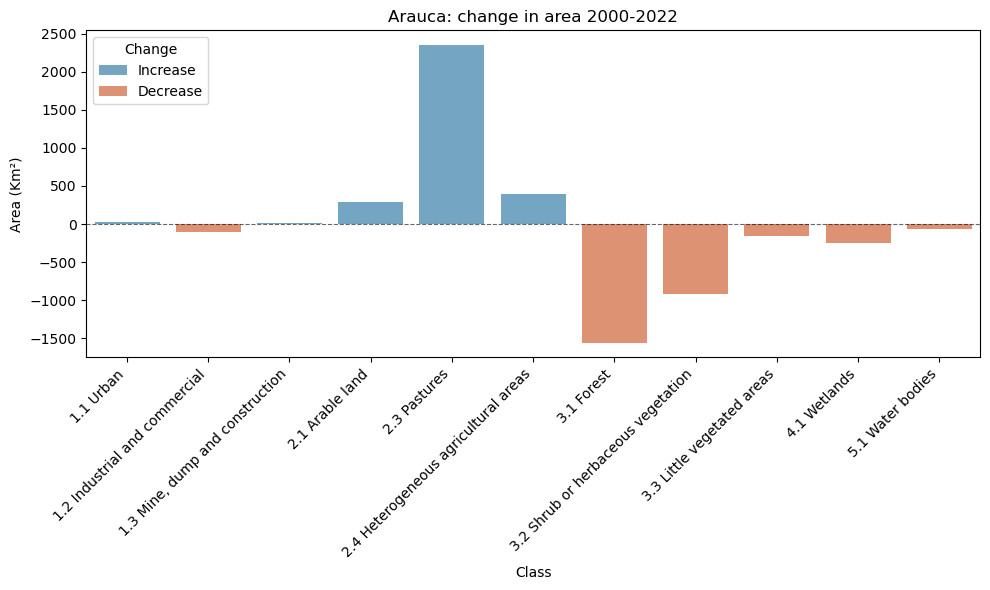

In [ ]:
ara_2000_2022 = pd.merge(ara_2000, ara_2022, on="level2", suffixes=('_2000', '_2022'))
ara_2000_2022["diff"] = ara_2000_2022["Area_2022"] - ara_2000_2022["Area_2000"]
ara_2000_2022["Change"] = ara_2000_2022["diff"].apply(lambda x: "Increase" if x > 0 else "Decrease")

plt.figure(figsize=(10, 6))
sns.barplot(data=ara_2000_2022,
            x="level2", 
            y="diff", 
            hue="Change", 
            palette=["#67a9cf", "#ef8a62"], 
            dodge=False,
            errorbar=None,
            order=sorted(ara_2000_2022["level2"].unique()))
plt.axhline(0, color="black", linestyle="--", linewidth=0.8, alpha=0.6)
plt.xlabel("Class")
plt.ylabel("Area (Km²)")
plt.title("Arauca: change in area 2000-2022")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Change", loc="upper left")
plt.tight_layout()

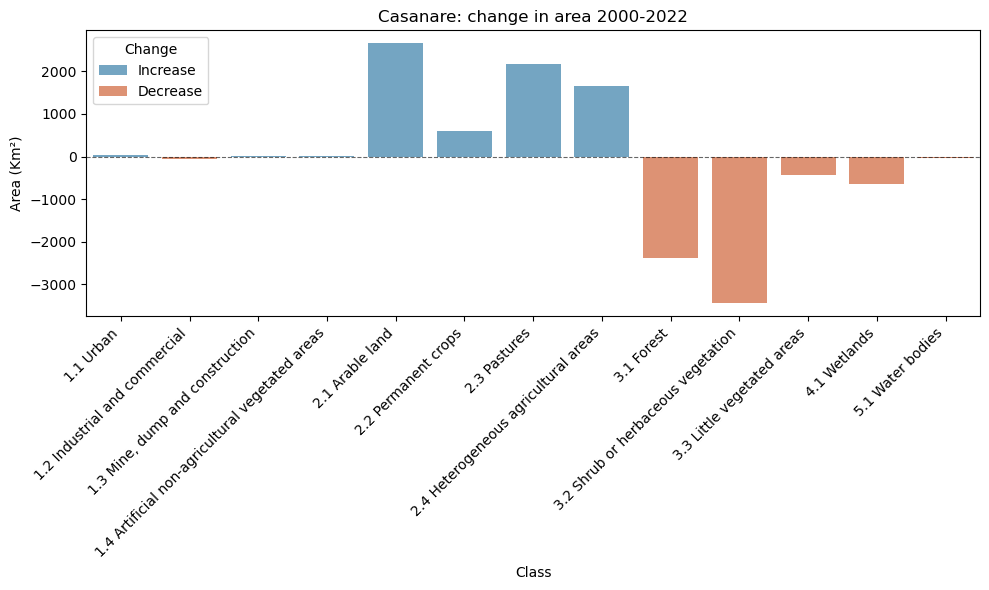

In [ ]:
casa_2000_2022 = pd.merge(casa_2000, casa_2022, on="level2", suffixes=('_2000', '_2022'))
casa_2000_2022["diff"] = casa_2000_2022["Area_2022"] - casa_2000_2022["Area_2000"]
casa_2000_2022["Change"] = casa_2000_2022["diff"].apply(lambda x: "Increase" if x > 0 else "Decrease")

plt.figure(figsize=(10, 6))
sns.barplot(data=casa_2000_2022,
            x="level2", 
            y="diff", 
            hue="Change", 
            palette=["#67a9cf", "#ef8a62"], 
            dodge=False,
            errorbar=None,
            order=sorted(casa_2000_2022["level2"].unique()))
plt.axhline(0, color="black", linestyle="--", linewidth=0.8, alpha=0.6)
plt.xlabel("Class")
plt.ylabel("Area (Km²)")
plt.title("Casanare: change in area 2000-2022")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Change", loc="upper left")
plt.tight_layout()

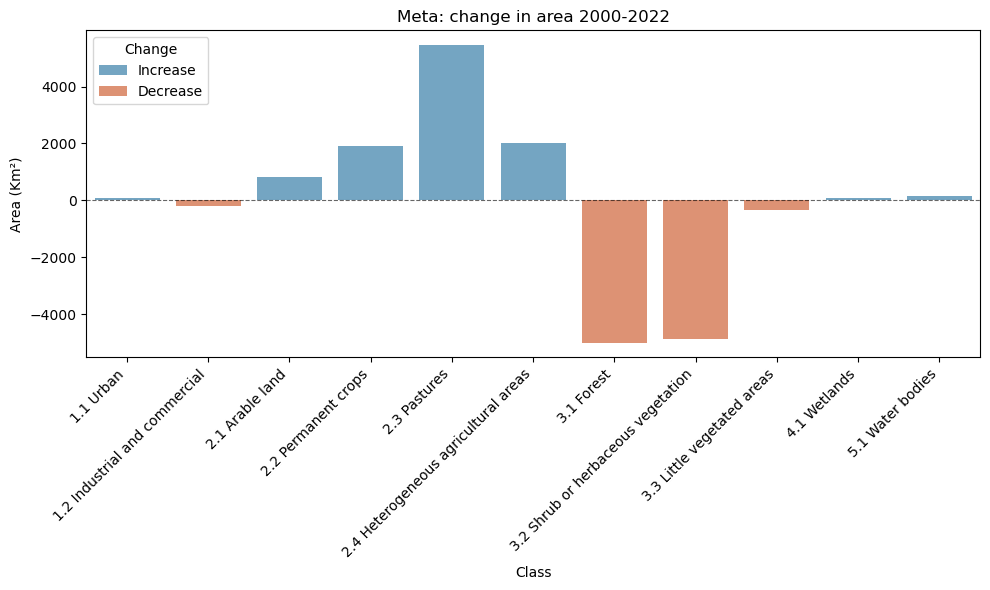

In [ ]:
meta_2000_2022 = pd.merge(meta_2000, meta_2022, on="level2", suffixes=('_2000', '_2022'))
meta_2000_2022["diff"] = meta_2000_2022["Area_2022"] - meta_2000_2022["Area_2000"]
meta_2000_2022["Change"] = meta_2000_2022["diff"].apply(lambda x: "Increase" if x > 0 else "Decrease")

plt.figure(figsize=(10, 6))
sns.barplot(data=meta_2000_2022,
            x="level2", 
            y="diff", 
            hue="Change", 
            palette=["#67a9cf", "#ef8a62"], 
            dodge=False,
            errorbar=None,
            order=sorted(meta_2000_2022["level2"].unique()))
plt.axhline(0, color="black", linestyle="--", linewidth=0.8, alpha=0.6)
plt.xlabel("Class")
plt.ylabel("Area (Km²)")
plt.title("Meta: change in area 2000-2022")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Change", loc="upper left")
plt.tight_layout()

### Merge 3 departments

In [ ]:
# Merge by year
lc_2000 = pd.concat([lc['ara_cover2000l2.gpkg'], lc['casa_cover2000l2.gpkg'], lc['meta_cover2000l2.gpkg']], ignore_index=True)
lc_2010 = pd.concat([lc['ara_cover2010l2.gpkg'], lc['casa_cover2010l2.gpkg'], lc['meta_cover2010l2.gpkg']], ignore_index=True)
lc_2022 = pd.concat([lc['ara_cover2020l2.gpkg'], lc['casa_cover2020l2.gpkg'], lc['meta_cover2020l2.gpkg']], ignore_index=True)

In [ ]:
# Calculate area in square kilometers and aggregate by 'level2'
lc_2000["Area"] = lc_2000.geometry.area / 1e6
lc_2000_area = lc_2000.groupby("level2")["Area"].sum().reset_index()

lc_2010["Area"] = lc_2010.geometry.area / 1e6
lc_2010_area = lc_2010.groupby("level2")["Area"].sum().reset_index()

lc_2022["Area"] = lc_2022.geometry.area / 1e6
lc_2022_area = lc_2022.groupby("level2")["Area"].sum().reset_index()

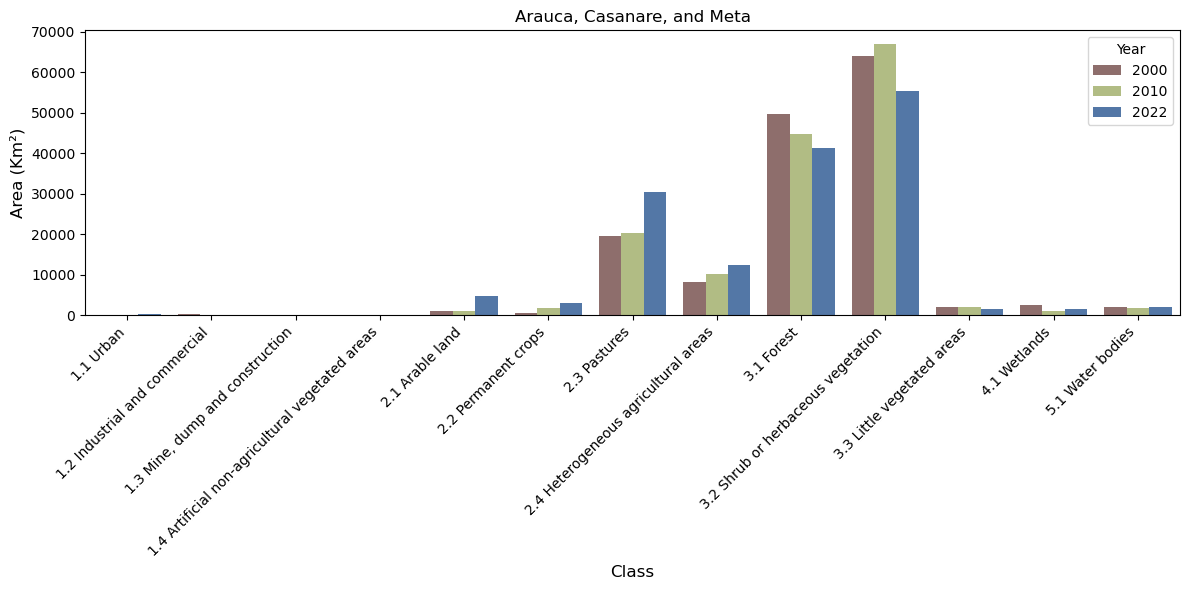

In [ ]:
# Add 'Year' column to each dataframe
lc_2000_area["Year"] = 2000
lc_2010_area["Year"] = 2010
lc_2022_area["Year"] = 2022

# Combine all years into one dataframe
lc_all = pd.concat([lc_2000_area, lc_2010_area, lc_2022_area], ignore_index=True)

lc_all_noclouds = lc_all[lc_all["level2"] != "9.9 Unknown"]

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=lc_all_noclouds,
    x="level2",
    y="Area",
    hue="Year",
    palette=["#946966", "#b6c57b", "#4575b4"] 
)

# Style the plot
plt.xlabel("Class", fontsize=12)
plt.ylabel("Area (Km²)", fontsize=12)
plt.title("Arauca, Casanare, and Meta")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Year")
plt.tight_layout()
plt.show()

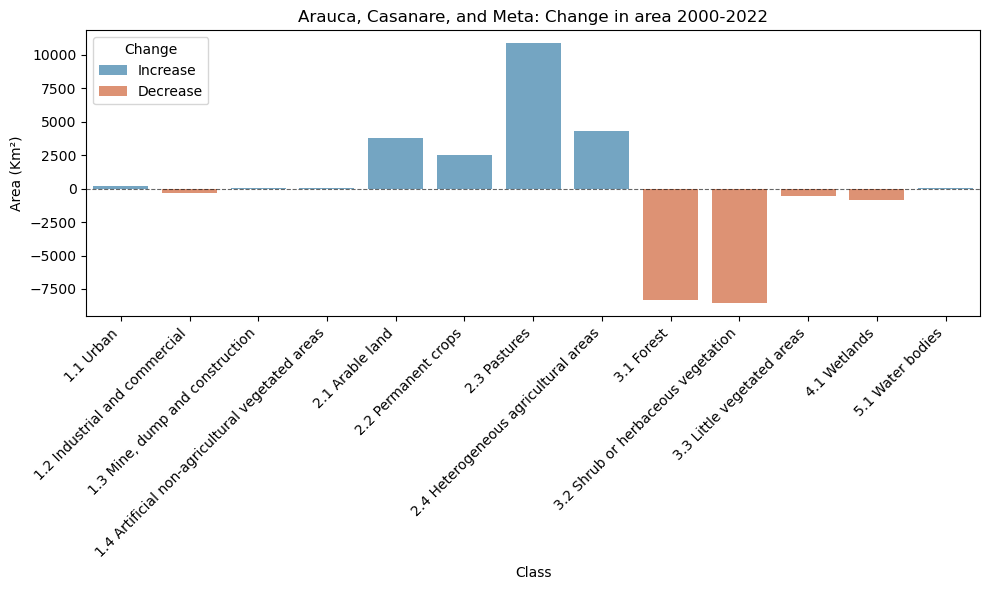

In [ ]:
lc_2000_2022 = pd.merge(lc_2000_area, lc_2022_area, on="level2", suffixes=('_2000', '_2022'))
lc_2000_2022 = lc_2000_2022[lc_2000_2022["level2"] != "9.9 Unknown"]
lc_2000_2022["diff"] = lc_2000_2022["Area_2022"] - lc_2000_2022["Area_2000"]
lc_2000_2022["Change"] = lc_2000_2022["diff"].apply(lambda x: "Increase" if x > 0 else "Decrease")  

plt.figure(figsize=(10, 6))
sns.barplot(x="level2", y="diff", data=lc_2000_2022, hue="Change", palette=["#67a9cf", "#ef8a62"], dodge=False)
plt.axhline(0, color="black", linestyle="--", linewidth=0.8, alpha=0.6)
plt.xlabel("Class")
plt.ylabel("Area (Km²)")
plt.title("Arauca, Casanare, and Meta: Change in area 2000-2022")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Change", loc="upper left")
plt.tight_layout()

### Sankey plot per department

Arauca

In [ ]:
inter=gpd.overlay(ara_2000,ara_2022,how='intersection')
if inter.crs.is_geographic:
    inter = inter.to_crs(epsg=9377)
inter['area']=inter.geometry.area/1e6

c:\Users\VICTUS\anaconda3\envs\osgeo-env-v1\lib\site-packages\ipykernel_launcher.py:1: UserWarning:

`keep_geom_type=True` in overlay resulted in 60463 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries



In [ ]:
ara_2022['level2'].unique()

array(['1.1 Urban', '1.2 Industrial and commercial',
       '1.3 Mine, dump and construction',
       '1.4 Artificial non-agricultural vegetated areas',
       '2.1 Arable land', '2.2 Permanent crops', '2.3 Pastures',
       '2.4 Heterogeneous agricultural areas', '3.1 Forest',
       '3.2 Shrub or herbaceous vegetation', '3.3 Little vegetated areas',
       '4.1 Wetlands', '5.1 Water bodies'], dtype=object)

In [ ]:
inter = inter.rename(columns={'level2_1': 'Date1','level2_2':'Date2'})

label_set = set()
links = []

def add_links(inter, col_from, col_to):
    temp = inter.groupby([col_from, col_to])["area"].sum().reset_index()
    for _, row in temp.iterrows():
        source = f"{col_from}_{row[col_from]}"
        target = f"{col_to}_{row[col_to]}"
        value = row["area"]
        label_set.update([source, target])
        links.append((source, target, value))

add_links(inter, "Date1", "Date2")

labels = list(label_set)
label_to_index = {label: i for i, label in enumerate(labels)}

source = [label_to_index[s] for s, t, v in links]
target = [label_to_index[t] for s, t, v in links]
value = [v for s, t, v in links]

color_dict = {
    "1.1 Urban": "#FD0000",
    "1.2 Industrial and commercial": "#B26E69",
    "1.3 Mine, dump and construction": "#4a4a4a",
    "1.4 Artificial non-agricultural vegetated areas": "#00CCBB",
    "2.1 Arable land": "#ffeb12",
    "2.2 Permanent crops": "#ED66C0",
    "2.3 Pastures": "#b3cd57",
    "2.4 Heterogeneous agricultural areas": "#CAB03E",
    "3.1 Forest": "#3a6a00",
    "3.2 Shrub or herbaceous vegetation": "#5f4d29",
    "3.3 Little vegetated areas": "#bfc5b9",
    "4.1 Wetlands": "#7faed5",
    "5.1 Water bodies": "#0127ff",
    "9.9 Unknown": "#FBF1F1"
}

display_labels = [label.split("_", 1)[1] for label in labels]

colors = []
for label in labels:
    class_name = label.split("_", 1)[1].strip()
    colors.append(color_dict.get(class_name, "gray"))

def hex_to_rgba(hex_color, alpha=0.6):
    hex_color = hex_color.lstrip("#")
    r, g, b = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
    return f"rgba({r},{g},{b},{alpha})"

missing_classes = set()
for s, t, v in links:
    class_name = s.split("_", 1)[1].strip()
    if class_name not in color_dict:
        missing_classes.add(class_name)

link_colors = []
for s, t, v in links:
    class_name = s.split("_", 1)[1].strip()
    hex_color = color_dict.get(class_name, "#999999")
    link_colors.append(hex_to_rgba(hex_color))

fig = go.Figure(data=[go.Sankey(
    arrangement="snap",
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=display_labels,
        color=colors
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=link_colors
    )
)])

fig.update_layout(
    title_text="Sankey plot 2000 and 2022 - Arauca",
    font_size=18,
    height=900
)

Casanare

In [ ]:
inter=gpd.overlay(casa_2000,casa_2022,how='intersection')
if inter.crs.is_geographic:
    inter = inter.to_crs(epsg=9377)
inter['area']=inter.geometry.area/1e6

c:\Users\VICTUS\anaconda3\envs\osgeo-env-v1\lib\site-packages\ipykernel_launcher.py:1: UserWarning:

`keep_geom_type=True` in overlay resulted in 155776 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries



In [ ]:
inter = inter.rename(columns={'level2_1': 'Date1','level2_2':'Date2'})

label_set = set()
links = []

def add_links(inter, col_from, col_to):
    temp = inter.groupby([col_from, col_to])["area"].sum().reset_index()
    for _, row in temp.iterrows():
        source = f"{col_from}_{row[col_from]}"
        target = f"{col_to}_{row[col_to]}"
        value = row["area"]
        label_set.update([source, target])
        links.append((source, target, value))

add_links(inter, "Date1", "Date2")

labels = list(label_set)
labels = sorted(label_set, key=lambda x: x.split("_", 1)[1])
label_to_index = {label: i for i, label in enumerate(labels)}

source = [label_to_index[s] for s, t, v in links]
target = [label_to_index[t] for s, t, v in links]
value = [v for s, t, v in links]

color_dict = {
    "1.1 Urban": "#FD0000",
    "1.2 Industrial and commercial": "#B26E69",
    "1.3 Mine, dump and construction": "#4a4a4a",
    "1.4 Artificial non-agricultural vegetated areas": "#00CCBB",
    "2.1 Arable land": "#ffeb12",
    "2.2 Permanent crops": "#ED66C0",
    "2.3 Pastures": "#b3cd57",
    "2.4 Heterogeneous agricultural areas": "#CAB03E",
    "3.1 Forest": "#3a6a00",
    "3.2 Shrub or herbaceous vegetation": "#5f4d29",
    "3.3 Little vegetated areas": "#bfc5b9",
    "4.1 Wetlands": "#7faed5",
    "5.1 Water bodies": "#0127ff",
    "9.9 Unknown": "#FBF1F1"
}

display_labels = [label.split("_", 1)[1] for label in labels]

colors = []
for label in labels:
    class_name = label.split("_", 1)[1].strip()
    colors.append(color_dict.get(class_name, "gray"))

def hex_to_rgba(hex_color, alpha=0.6):
    hex_color = hex_color.lstrip("#")
    r, g, b = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
    return f"rgba({r},{g},{b},{alpha})"

missing_classes = set()
for s, t, v in links:
    class_name = s.split("_", 1)[1].strip()
    if class_name not in color_dict:
        missing_classes.add(class_name)

link_colors = []
for s, t, v in links:
    class_name = s.split("_", 1)[1].strip()
    hex_color = color_dict.get(class_name, "#999999")
    link_colors.append(hex_to_rgba(hex_color))

fig = go.Figure(data=[go.Sankey(
    arrangement="snap",
    node=dict(
        pad=20,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=display_labels,
        color=colors
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=link_colors
    )
)])

fig.update_layout(
    title_text="Sankey plot 2000 and 2022 - Casanare",
    font_size=18,
    height=900
)

Meta

In [ ]:
inter=gpd.overlay(meta_2000,meta_2022,how='intersection')
if inter.crs.is_geographic:
    inter = inter.to_crs(epsg=9377)
inter['area']=inter.geometry.area/1e6

c:\Users\VICTUS\anaconda3\envs\osgeo-env-v1\lib\site-packages\ipykernel_launcher.py:1: UserWarning:

`keep_geom_type=True` in overlay resulted in 743087 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries



In [ ]:
inter = inter.rename(columns={'level2_1': 'Date1','level2_2':'Date2'})

label_set = set()
links = []

def add_links(inter, col_from, col_to):
    temp = inter.groupby([col_from, col_to])["area"].sum().reset_index()
    for _, row in temp.iterrows():
        source = f"{col_from}_{row[col_from]}"
        target = f"{col_to}_{row[col_to]}"
        value = row["area"]
        label_set.update([source, target])
        links.append((source, target, value))

add_links(inter, "Date1", "Date2")

labels = list(label_set)
labels = sorted(label_set, key=lambda x: x.split("_", 1)[1])
label_to_index = {label: i for i, label in enumerate(labels)}

source = [label_to_index[s] for s, t, v in links]
target = [label_to_index[t] for s, t, v in links]
value = [v for s, t, v in links]

color_dict = {
    "1.1 Urban": "#FD0000",
    "1.2 Industrial and commercial": "#B26E69",
    "1.3 Mine, dump and construction": "#4a4a4a",
    "1.4 Artificial non-agricultural vegetated areas": "#00CCBB",
    "2.1 Arable land": "#ffeb12",
    "2.2 Permanent crops": "#ED66C0",
    "2.3 Pastures": "#b3cd57",
    "2.4 Heterogeneous agricultural areas": "#CAB03E",
    "3.1 Forest": "#3a6a00",
    "3.2 Shrub or herbaceous vegetation": "#5f4d29",
    "3.3 Little vegetated areas": "#bfc5b9",
    "4.1 Wetlands": "#7faed5",
    "5.1 Water bodies": "#0127ff",
    "9.9 Unknown": "#FBF1F1"
}

display_labels = [label.split("_", 1)[1] for label in labels]

colors = []
for label in labels:
    class_name = label.split("_", 1)[1].strip()
    colors.append(color_dict.get(class_name, "gray"))

def hex_to_rgba(hex_color, alpha=0.6):
    hex_color = hex_color.lstrip("#")
    r, g, b = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
    return f"rgba({r},{g},{b},{alpha})"

missing_classes = set()
for s, t, v in links:
    class_name = s.split("_", 1)[1].strip()
    if class_name not in color_dict:
        missing_classes.add(class_name)

link_colors = []
for s, t, v in links:
    class_name = s.split("_", 1)[1].strip()
    hex_color = color_dict.get(class_name, "#999999")
    link_colors.append(hex_to_rgba(hex_color))


fig = go.Figure(data=[go.Sankey(
    arrangement="snap",
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=display_labels,
        color=colors
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=link_colors
    )
)])

fig.update_layout(
    title_text="Sankey plot 2000 and 2022 - Meta",
    font_size=18,
    height=900
)

### Sankey plot, all departments merged

In [ ]:
inter=gpd.overlay(lc_2000,lc_2022,how='intersection')
if inter.crs.is_geographic:
    inter = inter.to_crs(epsg=9377)
inter['area']=inter.geometry.area/1e6

c:\Users\VICTUS\anaconda3\envs\osgeo-env-v1\lib\site-packages\ipykernel_launcher.py:1: UserWarning:

`keep_geom_type=True` in overlay resulted in 366662 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries



In [ ]:
inter = inter.rename(columns={'level2_1': 'Date1','level2_2':'Date2'})

label_set = set()
links = []

def add_links(inter, col_from, col_to):
    temp = inter.groupby([col_from, col_to])["area"].sum().reset_index()
    for _, row in temp.iterrows():
        source = f"{col_from}_{row[col_from]}"
        target = f"{col_to}_{row[col_to]}"
        value = row["area"]
        label_set.update([source, target])
        links.append((source, target, value))

add_links(inter, "Date1", "Date2")

labels = list(label_set)
labels = sorted(label_set, key=lambda x: x.split("_", 1)[1])
label_to_index = {label: i for i, label in enumerate(labels)}

source = [label_to_index[s] for s, t, v in links]
target = [label_to_index[t] for s, t, v in links]
value = [v for s, t, v in links]

color_dict = {
    "1.1 Urban": "#FD0000",
    "1.2 Industrial and commercial": "#B26E69",
    "1.3 Mine, dump and construction": "#4a4a4a",
    "1.4 Artificial non-agricultural vegetated areas": "#00CCBB",
    "2.1 Arable land": "#ffeb12",
    "2.2 Permanent crops": "#ED66C0",
    "2.3 Pastures": "#b3cd57",
    "2.4 Heterogeneous agricultural areas": "#CAB03E",
    "3.1 Forest": "#3a6a00",
    "3.2 Shrub or herbaceous vegetation": "#5f4d29",
    "3.3 Little vegetated areas": "#bfc5b9",
    "4.1 Wetlands": "#7faed5",
    "5.1 Water bodies": "#0127ff",
    "9.9 Unknown": "#FBF1F1"
}

display_labels = [label.split("_", 1)[1] for label in labels]

colors = []
for label in labels:
    class_name = label.split("_", 1)[1].strip()
    colors.append(color_dict.get(class_name, "gray"))

def hex_to_rgba(hex_color, alpha=0.6):
    hex_color = hex_color.lstrip("#")
    r, g, b = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
    return f"rgba({r},{g},{b},{alpha})"

missing_classes = set()
for s, t, v in links:
    class_name = s.split("_", 1)[1].strip()
    if class_name not in color_dict:
        missing_classes.add(class_name)

link_colors = []
for s, t, v in links:
    class_name = s.split("_", 1)[1].strip()
    hex_color = color_dict.get(class_name, "#999999")
    link_colors.append(hex_to_rgba(hex_color))

fig = go.Figure(data=[go.Sankey(
    arrangement="snap",
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=display_labels,
        color=colors
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=link_colors
    )
)])

fig.update_layout(
    title_text="Sankey plot 2000 and 2022",
    font_size=12,
    height=900
)

### Land cover gain and losses

In [124]:
# List of dataframes and their names
depts_data = {
    "Arauca": ara_level2_year,
    "Casanare": casa_level2_year,
    "Meta": meta_level2_year
}

final_tables = {}

for name, df in depts_data.items():
    # 1. Pivot the data to get years as columns
    # We sum the Area just in case there are duplicate level2 entries
    summary = df.pivot_table(index='level2', columns='year', values='Area', aggfunc='sum')
    
    # 2. Ensure all three years exist (even if 0) to avoid calculation errors
    for yr in [2000, 2010, 2022]:
        if yr not in summary.columns:
            summary[yr] = 0.0
            
    # 3. Calculate change columns
    summary['2000-2010'] = summary[2010] - summary[2000]
    summary['2010-2022'] = summary[2022] - summary[2010]
    summary['2000-2022'] = summary[2022] - summary[2000]
    
    # 4. Formatting: Fill NaNs, round, and reset index
    summary = summary.fillna(0).round(2).reset_index()
    
    # Store and Print
    final_tables[name] = summary
    print(f"\n{'='*30}")
    print(f"Land Cover Area Changes - {name}")
    print(f"{'='*30}")
    print(summary.to_string(index=False))

    #Save each one to a separate CSV
    summary.to_csv(f"./cover_change/land_cover_changes_{name.lower()}.csv", index=False)


Land Cover Area Changes - Arauca
                                         level2     2000     2010     2022  2000-2010  2010-2022  2000-2022
                                      1.1 Urban    20.94    29.88    41.70       8.93      11.82      20.76
                  1.2 Industrial and commercial   112.27    39.04     3.68     -73.23     -35.36    -108.59
                1.3 Mine, dump and construction     5.92     8.58    14.21       2.66       5.63       8.29
1.4 Artificial non-agricultural vegetated areas     0.00     0.00     0.40       0.00       0.00       0.00
                                2.1 Arable land     0.57     0.00   294.42       0.00       0.00     293.84
                            2.2 Permanent crops     0.00     0.00     3.13       0.00       0.00       0.00
                                   2.3 Pastures  2937.06  3190.99  5286.40     253.93    2095.41    2349.34
           2.4 Heterogeneous agricultural areas   883.88   886.48  1280.92       2.60     394.44     3

In [125]:
# Create comprehensive table for all departments merged
lc_2000_2010 = pd.merge(lc_2000_area, lc_2010_area, on="level2", suffixes=('_2000', '_2010'))
lc_all_years = pd.merge(lc_2000_2010, lc_2022_area.rename(columns={'Area': 'Area_2022'}), on="level2")

# Rename Area columns 
lc_all_years = lc_all_years.rename(columns={'Area_2000': '2000', 'Area_2010': '2010', 'Area_2022': '2022'})

# Calculate changes
lc_all_years['2000-2010'] = lc_all_years['2010'] - lc_all_years['2000']
lc_all_years['2010-2022'] = lc_all_years['2022'] - lc_all_years['2010']
lc_all_years['2000-2022'] = lc_all_years['2022'] - lc_all_years['2000']

# Round to 1 decimal place
lc_all_years = lc_all_years.round(2)

# Reorder columns for better readability
lc_all_years = lc_all_years[['level2', '2000', '2010', '2022', 
                              '2000-2010', '2010-2022', '2000-2022']]

# Sort by level2 class name
lc_all_years = lc_all_years.sort_values('level2').reset_index(drop=True)

# Display the table
print("Land Cover Area Changes - All Departments (Arauca, Casanare, Meta)")
print(lc_all_years.to_string())

# Save to CSV
lc_all_years.to_csv('./cover_change/land_cover_changes_all.csv', index=False)

Land Cover Area Changes - All Departments (Arauca, Casanare, Meta)
                                             level2      2000      2010      2022  2000-2010  2010-2022  2000-2022
0                                         1.1 Urban    104.59    161.49    261.12      56.90      99.63     156.53
1                     1.2 Industrial and commercial    404.98     44.53     57.65    -360.45      13.12    -347.33
2                   1.3 Mine, dump and construction     11.41     18.03     61.04       6.62      43.01      49.63
3   1.4 Artificial non-agricultural vegetated areas      0.36      8.57     16.99       8.20       8.42      16.63
4                                   2.1 Arable land   1016.33   1078.18   4795.29      61.85    3717.11    3778.95
5                               2.2 Permanent crops    642.26   1875.76   3158.34    1233.50    1282.58    2516.08
6                                      2.3 Pastures  19644.49  20393.68  30499.03     749.19   10105.35   10854.55
7            